Welcome to our first exercise with Colab!

Today we'll be experimenting with ping and Scapy and refresh some of the Python programming language features.

As a first step, we need to install scapy and pythonping libraries. You can install new Python libraries in your Colab notebook using 
```
!pip install <library>
```



In [1]:
!pip install --pre scapy[basic]
!pip install pythonping

     |████████████████████████████████| 1.1 MB 5.1 MB/s 
  Created wheel for scapy: filename=scapy-2.4.5-py2.py3-none-any.whl size=1261555 sha256=7d8bd59dae6120f0c75a9eeb72dbd68b89b83d64bead419412ee8e71aadf4227
  Stored in directory: /root/.cache/pip/wheels/b9/6e/c0/0157e466a5e02d3ff28fc7587dff329b4a967a23b3f9b11385
Successfully built scapy


Now we'll try to figure out what is the public (external) IP address of the Virtual Machine we are running. We'll do it by asking to the *ipify* API (similar to searching for 'what is my ip' on google). We can also try to localize the VM geographically by using the *ip-api* service.

In [ ]:
import numpy as np

import json # parse the reply
import socket
import urllib.request

from pythonping import ping
from scapy.all import *

import matplotlib as mpl
import matplotlib.pyplot as plt


In [ ]:
ip = urllib.request.urlopen('https://api.ipify.org').read().decode('UTF-8')
ip_info = json.loads(urllib.request.urlopen('http://ip-api.com/json/' + ip).read())

# what is the IP of the VM you use in colab
print('External IP: ', ip)
print('Organization: ', ip_info["org"])
print('Location: ', ip_info["city"], ',', ip_info["country"])

External IP:  104.198.3.56
Organization:  Google Cloud (us-west1)
Location:  The Dalles , United States


OK! So every measurement we'll do from this page is performed from the Google Cloud servers (location may vary!). Now, we'll use python native ping library to ping a server far away... say in New Zealand (using the debian mirror server ftp.nz.debian.org)

In [ ]:
target = 'ftp.nz.debian.org'
ping(target, verbose=False, count=20)

Reply from 163.7.134.112, 29 bytes in 152.77ms
Reply from 163.7.134.112, 29 bytes in 153.02ms
Reply from 163.7.134.112, 29 bytes in 152.31ms
Reply from 163.7.134.112, 29 bytes in 154.89ms
Reply from 163.7.134.112, 29 bytes in 152.66ms
Reply from 163.7.134.112, 29 bytes in 153.62ms
Reply from 163.7.134.112, 29 bytes in 152.98ms
Reply from 163.7.134.112, 29 bytes in 152.61ms
Reply from 163.7.134.112, 29 bytes in 152.29ms
Reply from 163.7.134.112, 29 bytes in 151.85ms
Reply from 163.7.134.112, 29 bytes in 151.68ms
Reply from 163.7.134.112, 29 bytes in 151.77ms
Reply from 163.7.134.112, 29 bytes in 151.8ms
Reply from 163.7.134.112, 29 bytes in 151.85ms
Reply from 163.7.134.112, 29 bytes in 151.96ms
Reply from 163.7.134.112, 29 bytes in 151.87ms
Reply from 163.7.134.112, 29 bytes in 151.82ms
Reply from 163.7.134.112, 29 bytes in 152.02ms
Reply from 163.7.134.112, 29 bytes in 151.84ms
Reply from 163.7.134.112, 29 bytes in 151.81ms

Round Trip Times min/avg/max is 151.68/152.37/154.89 ms

Perfect! That was simple, and we already got some network measurements (Round Trip Times)!

Now we will try to use scapy to do the same thing. We will create several ICMP echo request packet, send it to our target server and wait for the response. Let's try to understand how scapy works.

First we will understand how to create packets by stacking protocol layers

In [ ]:
#default IP layer
IP().show()

#default ICMP layer
ICMP().show()

#default UDP layer
UDP().show()

#default TCP layer
TCP().show()

#create a simple ICMP echo request packet with IP destination 'ftp.nz.debian.org'. You can stack layers with the '/' operand.
packet = IP(dst = target) / ICMP()
packet.show()

###[ IP ]### 
  version   = 4
  ihl       = None
  tos       = 0x0
  len       = None
  id        = 1
  flags     = 
  frag      = 0
  ttl       = 64
  proto     = 0
  chksum    = None
  src       = 127.0.0.1
  dst       = 127.0.0.1
  \options   \

###[ ICMP ]### 
  type      = echo-request
  code      = 0
  chksum    = None
  id        = 0x0
  seq       = 0x0
  unused    = ''

###[ UDP ]### 
  sport     = 53
  dport     = 53
  len       = None
  chksum    = None

###[ TCP ]### 
  sport     = 20
  dport     = 80
  seq       = 0
  ack       = 0
  dataofs   = None
  reserved  = 0
  flags     = S
  window    = 8192
  chksum    = None
  urgptr    = 0
  options   = ''

###[ IP ]### 
  version   = 4
  ihl       = None
  tos       = 0x0
  len       = None
  id        = 1
  flags     = 
  frag      = 0
  ttl       = 64
  proto     = 1
  chksum    = None
  src       = 172.28.0.2
  dst       = Net("ftp.nz.debian.org/32")
  \options   \
###[ ICMP ]### 
     type      = echo-request
     code     

Now we'll send the packet we have created. The sr() function can be used to send packets and receive answers at the IP layer. 

The sr() function returns two outputs: i) a couple of packets sent and answers received and ii) the unanswered packets. 

```
ans, unans = sr(packet)
```

The structure of the object for answered packets is the following: ans[i][0] stores the i-th sent packet, ans[i][1] the i-th received response 



In [ ]:
ans, unans = sr(packet, verbose = False)
print('Received ', len(ans), 'packet')
print(ans.summary())
query = ans[0][0]
answer = ans[0][1]
print(query.summary())
print(answer.summary())

Received  1 packet
IP / ICMP 172.28.0.2 > 163.7.134.112 echo-request 0 ==> IP / ICMP 163.7.134.112 > 172.28.0.2 echo-reply 0
None
IP / ICMP 172.28.0.2 > 163.7.134.112 echo-request 0
IP / ICMP 163.7.134.112 > 172.28.0.2 echo-reply 0


We can also get some timing info from the sent/received packets...





In [ ]:
print(query.sent_time)
print(answer.time)
rtt = answer.time - query.sent_time
print(rtt*1000) #in ms
#NAT performs the translation, the OS will decode the right srs address

1645452174.1191776
1645452174.2720978
152.92024612426758


Ok! Now you should have all the ingredients to create your own version of ping using scapy tools. 

Let's send 20 ICMP echo request packets to ftp.nz.debian.org, compute the min/avg/max Round Trip Time and compare it with the pythonping output

In [ ]:
#Insert your solution here
RTT = []
for x in range(20):
  packet = IP(dst = target) / ICMP(type = 'echo-request',seq=x)
  ans, unans = sr(packet, verbose = False)
  RTT.append((ans[0][1].time - ans[0][0].sent_time)*1000) #in ms

print('Round Trip Times min/avg/max','%.2f' % min(RTT),'%.2f' % (sum(RTT)/len(RTT)), '%.2f' % max(RTT))

Round Trip Times min/avg/max 151.66 151.86 152.47


Very good! Now let's move to traceroute. First we'll see the command line version


In [ ]:
!apt-get install traceroute
!traceroute ftp.nz.debian.org

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following packages were automatically installed and are no longer required:
  cuda-command-line-tools-10-0 cuda-command-line-tools-10-1
  cuda-command-line-tools-11-0 cuda-compiler-10-0 cuda-compiler-10-1
  cuda-compiler-11-0 cuda-cuobjdump-10-0 cuda-cuobjdump-10-1
  cuda-cuobjdump-11-0 cuda-cupti-10-0 cuda-cupti-10-1 cuda-cupti-11-0
  cuda-cupti-dev-11-0 cuda-documentation-10-0 cuda-documentation-10-1
  cuda-documentation-11-0 cuda-documentation-11-1 cuda-gdb-10-0 cuda-gdb-10-1
  cuda-gdb-11-0 cuda-gpu-library-advisor-10-0 cuda-gpu-library-advisor-10-1
  cuda-libraries-10-0 cuda-libraries-10-1 cuda-libraries-11-0
  cuda-memcheck-10-0 cuda-memcheck-10-1 cuda-memcheck-11-0 cuda-nsight-10-0
  cuda-nsight-10-1 cuda-nsight-11-0 cuda-nsight-11-1 cuda-nsight-compute-10-0
  cuda-nsight-compute-10-1 cuda-nsight-compute-11-0 cuda-nsight-compute-11-1
  cuda-nsight-systems-10-1 cuda-nsight-systems-

Very good! Now, let's try to implement traceroute. The desired output should be something like this

1.   IP address of the first router on the path - RTT
2.   IP address of the second router on the path - RTT
etc...

you can stop sending ICMP requests when you reach the address of the target (hint: you can use socket.gethostbyname(target) to ask the DNS for the IP address of the target. import socket library first.)


```
import socket
target_ip = socket.gethostbyname(target)
```

IMPORTANT: some of the routers on the path to the destination may not reply to ICMP packets. You can manage this by putting a timeout on the sr() function and printing '***' if no response is received (sr() will return null). Example:

```
ans, unans = sr(packet, timeout = 10)
```






In [ ]:
#Insert your solution here
target_ip = socket.gethostbyname(target) 
for x in range(64):
  packet = IP(dst = target, ttl = x+1) / ICMP(type = 'echo-request',seq=x)
  ans, unans = sr(packet, verbose = False, timeout = 5)
  if(len(ans)>0):
    query = ans[0][0]
    answer = ans[0][1]
    rtt = (answer.time - query.sent_time)*1000
    print(x+1, '\t', answer.src, '\t','%.2f' % rtt, '\t',answer[ICMP].type) #ICMP types: 0 - echo reply, 11 - time exceeded 
    if(ans[0][1].src == target_ip):
      break;
  else:
    print(x+1, '\t', '***')

1 	 172.28.0.1 	 0.06 	 11
2 	 209.85.241.14 	 7.37 	 11
3 	 206.81.81.203 	 6.56 	 11
4 	 210.7.33.244 	 55.79 	 11
5 	 210.7.33.246 	 149.83 	 11
6 	 210.7.33.242 	 150.12 	 11
7 	 163.7.134.120 	 152.49 	 11
8 	 163.7.134.112 	 151.83 	 0


How to deal with devices non-replying to ICMP? Well, if it's a server that we are pinging, and we know that it accepts TCP connections on a known port (e.g. 80 for HTTP), we can try to do a TCP ping: we'll use a SYN packet as a request and get the SYN-ACK packet as a reply.

Let's try this for the www.polimi.it server. It will not reply to ICMP ping, but it will accept a TCP connection on port 80. 

In [ ]:
#Insert your solution here
icmp_request = IP(dst = "www.polimi.it") / ICMP()
ans,unans = sr(icmp_request, verbose = False, timeout = 5)
if(len(ans)>0):
  print('ICMP request answered')
else:
  print('ICMP request not answered')

tcp_syn = IP(dst = "www.polimi.it") / TCP(dport = 80, flags = 'S')
ans,unans = sr(tcp_syn, verbose = False, timeout = 5)

if(len(ans)>0):
  query = ans[0][0]
  answer = ans[0][1]
  rtt = (answer.time - query.sent_time)*1000
  print('TCP ping answered. RTT = ', '%.2f' % rtt)

else:
  print('TCP ping not answered')


ICMP request not answered
TCP ping answered. RTT =  148.69


Finally, we'll move some steps into visualizing the measurements we have gathered. As a first step, we will just run a ping and visualize on a time series axis the measurements taken. We'll use matplotlib and numpy library for that (no need for installation... they are already installed in Colab)





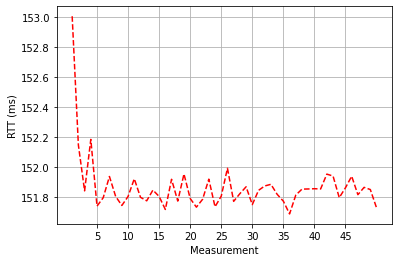

In [ ]:
RTT = []
num_measurements = 50
for x in range(num_measurements):
  packet = IP(dst = target) / ICMP(type = 'echo-request',seq=x)
  ans, unans = sr(packet, verbose = False)
  RTT.append((ans[0][1].time - ans[0][0].sent_time)*1000) #in ms

#create a linspace from 1 to num_measurements with num_measurements points
x = np.linspace(1, len(RTT), len(RTT))
fig = plt.figure()
plt.plot(x,RTT, '--r')

#improve figure
plt.xlabel("Measurement")
plt.ylabel("RTT (ms)")
plt.xticks(np.arange(5, num_measurements, step=num_measurements/10))
plt.grid(visible=True)